In [8]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Pranay\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Reference:
http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb

In [47]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [48]:
data = data.rename(columns={'#Passengers': 'Passengers'})

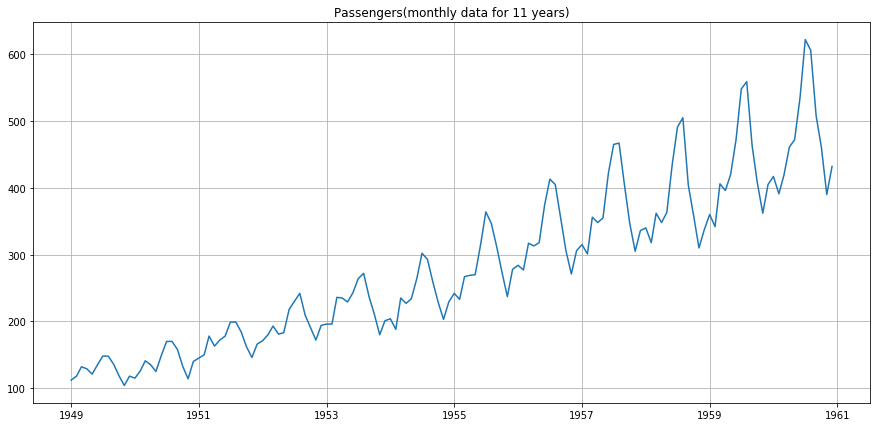

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(data.Passengers)
plt.grid(True)
plt.title('Passengers(monthly data for 11 years)')
plt.show()

In [5]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [4]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
def mean_absolute_percent_error(y_pred,y_true):
    return np.mean(np.abs(y_true-y_pred)/y_true)*100

In [7]:
list=[1,2,3,4]
print(list[2:])

[3, 4]


In [5]:
#for k previous values-moving average 
def move_average(series,n):
    return np.mean(series[-n:])

In [9]:
#last day prediction 
move_average(data,143)

Passengers    281.475524
dtype: float64

# moving average

In [6]:
def plotMovingAverage(series,window,plot_intervals=False,plot_anomalies=False,scale=1.96):
    rolling_mean=series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_intervals:
        mae=mean_absolute_error(series[window:],rolling_mean[window:])
        deviation=np.std(series[window:]-rolling_mean[window:])
        lower_bond=rolling_mean-(mae+deviation*scale)
        upper_bond=rolling_mean+(mae+deviation*scale)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:],label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)

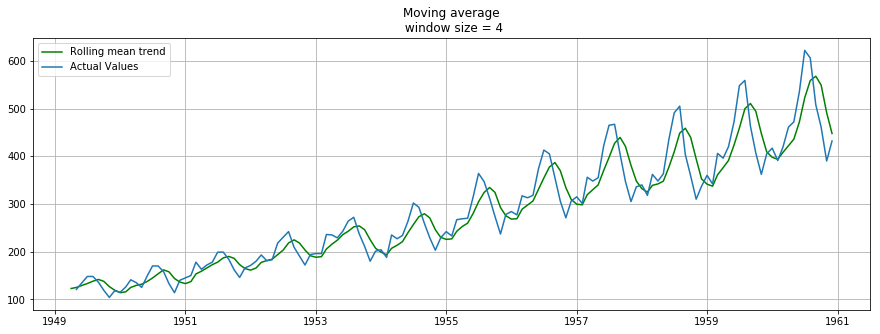

In [7]:
plotMovingAverage(data,4)

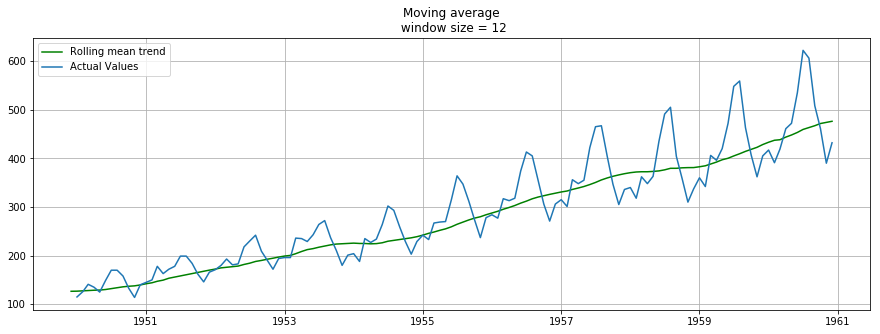

In [8]:
plotMovingAverage(data,12)

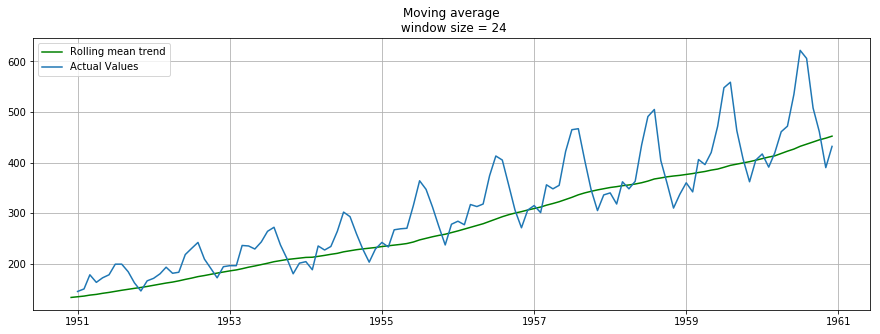

In [63]:
plotMovingAverage(data,24)

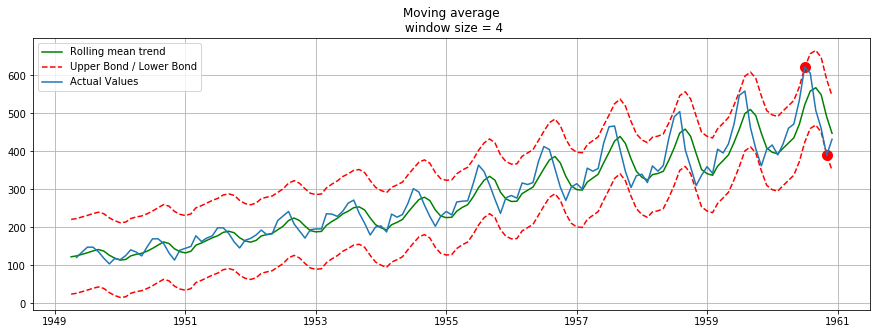

In [74]:
plotMovingAverage(data,4,plot_intervals=True,plot_anomalies=True)

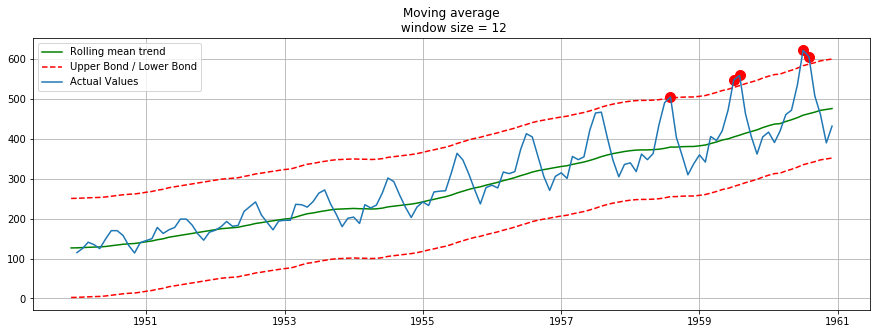

In [99]:
plotMovingAverage(data,12,plot_intervals=True,plot_anomalies=True)

# Weighted average

In [100]:
data.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [102]:
data.iloc[-6-1]

Passengers    535
Name: 1960-06-01 00:00:00, dtype: int64

In [103]:
weights=[0.6, 0.3, 0.1]

In [9]:
def weighted_average(series,weights):
    results=0
    weights.reverse()
    for n in range(len(weights)):
        results=results+data.iloc[-n-1]*weights[n]
    return float(results)

In [122]:
weighted_average(data,[0.6,0.3,0.1])

436.79999999999995

# Exponential Smoothening 

In [13]:
def exponential_smoothing(series,alpha):
    results=[series[0]]
    for i in range(1,len(series)):
        results.append(alpha*series[i] + (1-alpha)*results[i-1])
    return results

In [14]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

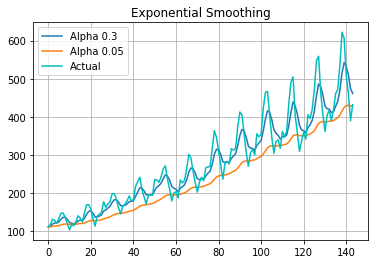

In [17]:
plotExponentialSmoothing(data.Passengers,[0.3,0.05])

# Double and Triple Exponential Smoothing 

Double Exponential Smoothing 

In [2]:
def double_exponential(series,alpha,beta):
    result=[series[0]]
    for n in range(1,len(series)+1):
        if n==1:
            level,trend=series[0],series[1]-series[0]
        if n>=len(series):
            value=result[-1]
        else:
            value=series[n]
            last_level,level=level,alpha*value + (1-alpha)*(level+trend)
            trend=beta*(level-last_level) + (1-beta)*trend
            result.append(level+trend)
    return result            

In [5]:
series = [3,10,12,13,12,10,12]
double_exponential(series, alpha=0.9, beta=0.9)

[3,
 17.0,
 15.45,
 14.210500000000001,
 11.396044999999999,
 8.183803049999998,
 12.753698384500002]

triple exponential 

In [6]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

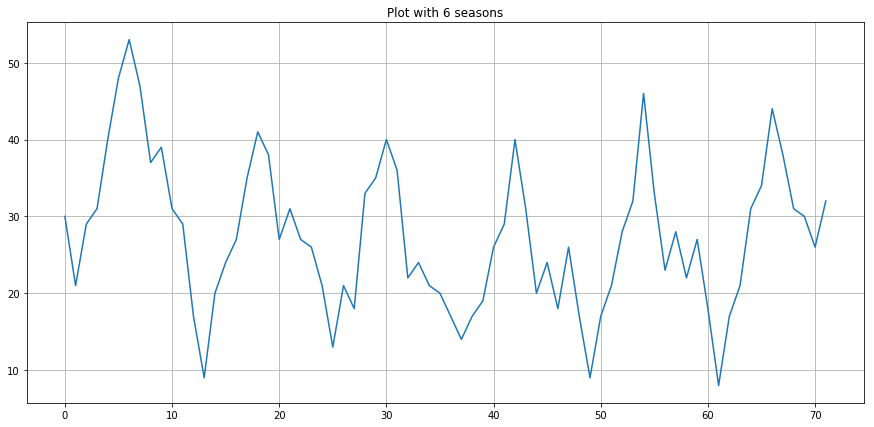

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(series)
plt.grid(True)
plt.title('Plot with 6 seasons')
plt.show()

In [13]:
#initial trend 
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [14]:
initial_trend(series,12)

-0.7847222222222222

In [15]:
#initial season component for level
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [16]:
initial_seasonal_components(series, 12)

{0: -7.4305555555555545,
 1: -15.097222222222221,
 2: -7.263888888888888,
 3: -5.097222222222222,
 4: 3.402777777777778,
 5: 8.069444444444445,
 6: 16.569444444444446,
 7: 9.736111111111112,
 8: -0.7638888888888887,
 9: 1.902777777777778,
 10: -3.263888888888889,
 11: -0.7638888888888887}

In [17]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [18]:
triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24)

[30,
 20.34449316666667,
 28.410051892109554,
 30.438122252647577,
 39.466817731253066,
 47.54961891047195,
 52.52339682497974,
 46.53453460769274,
 36.558407328055765,
 38.56283307754578,
 30.51864332437879,
 28.425963657825292,
 16.30247725646635,
 8.228588857142476,
 19.30036874234319,
 23.38657154193773,
 26.323990741396006,
 34.356648660113095,
 40.36971459184453,
 37.44298129818558,
 26.469996240541015,
 30.51819842804787,
 26.580158132275145,
 25.556750355604414,
 20.59232938487544,
 12.557525846506284,
 20.536167580315634,
 17.449559582909338,
 32.589947392978274,
 34.559067611499714,
 39.524706984702796,
 35.54354494552727,
 21.507741573047714,
 23.48782855767762,
 20.541994359470845,
 19.543228201110367,
 16.60700323688017,
 13.697607405158983,
 16.621224546074888,
 18.619564648649416,
 25.57626419227017,
 28.544672577127326,
 39.62603432821338,
 30.578678843303678,
 19.58514452366992,
 23.614663453052163,
 17.606991212001635,
 25.767260902774442,
 16.759148937441683,
 8.7128

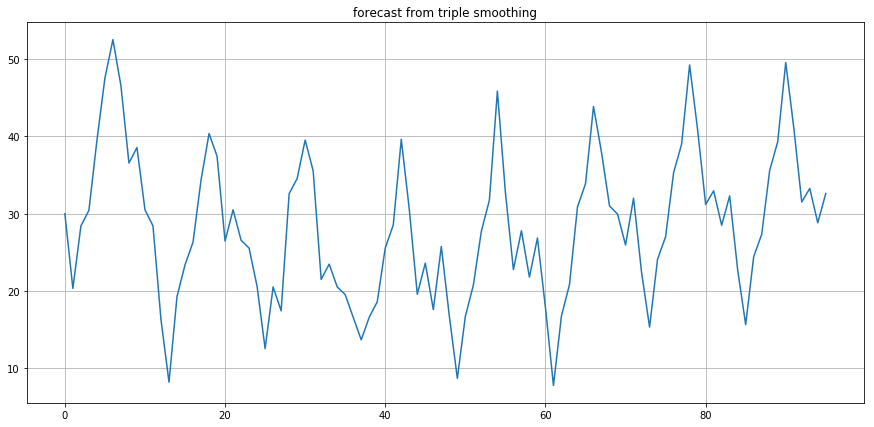

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24))
plt.grid(True)
plt.title('forecast from triple smoothing')
plt.show()

In [38]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

##  Cross Validation 

In [23]:
from sklearn.model_selection import TimeSeriesSplit
def timeseriesCVscore(params,series,loss_function='mean_squared_error',slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    errors=[]
    values=series.alpha
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
     # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In the Holt-Winters model, as well as in the other models of exponential smoothing, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient.

In [57]:
"""%%time
#dt=data.Passengers[:-20] # leave some data for testing
dt = data.Passengers.astype(float)

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 
# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(dt, 'mean_squared_log_error'), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )
# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(dt, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 10, scaling_factor = 3)
model.triple_exponential_smoothing()"""

'%%time\n#dt=data.Passengers[:-20] # leave some data for testing\ndt = data.Passengers.astype(float)\n\n# initializing model parameters alpha, beta and gamma\nx = [0, 0, 0] \n# Minimizing the loss function \nopt = minimize(timeseriesCVscore, x0=x, \n               args=(dt, \'mean_squared_log_error\'), \n               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))\n              )\n# Take optimal values...\nalpha_final, beta_final, gamma_final = opt.x\nprint(alpha_final, beta_final, gamma_final)\n\n# ...and train the model with them, forecasting for the next 50 hours\nmodel = HoltWinters(dt, slen = 12, \n                    alpha = alpha_final, \n                    beta = beta_final, \n                    gamma = gamma_final, \n                    n_preds = 10, scaling_factor = 3)\nmodel.triple_exponential_smoothing()'